In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, fsolve
from tqdm import tqdm
import sys
sys.path.append('../')
from lib.findiff import *

# 1D

In [25]:
class grad():
    def __init__(self,dx):
        self.dx = dx
    def _eval(self,v):
        Grad = lambda v: np.gradient(v,self.dx,edge_order=2)
        return Grad(v)

# Dirichlet

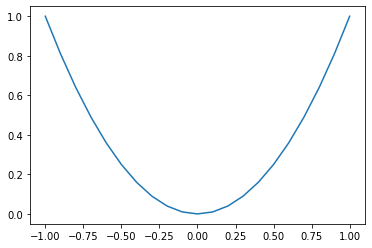

In [26]:
n = 20
x = np.linspace(-1,1,n+1)
f = np.linspace(-2,2,n+1)
boundary = np.zeros(n+1); boundary[0]=1
interior = np.ones(n+1)-boundary
g = np.zeros(n+1); g[0]=1
D = grad(x[1]-x[0])
residual = lambda v: interior*(D._eval(v)-f)+boundary*(v-g)
sol = fsolve(residual,np.zeros(n+1))
plt.plot(x,sol)

# Neumann

[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6
  0.8  1.   1.2  1.4  1.6  1.8  2. ]


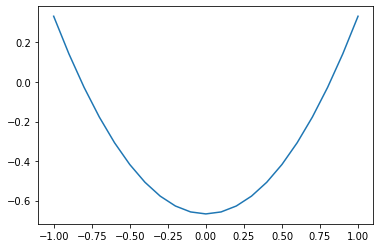

In [27]:
n = 20
x = np.linspace(-1,1,n+1)
f = np.linspace(-2,2,n+1)
boundary = np.zeros(n+1); boundary[0]=1
interior = np.ones(n+1)-boundary
g = np.zeros(n+1); g[0]=-2
D = grad(x[1]-x[0])
residual = lambda v: D._eval(v) - interior*(f)-boundary*(g)
sol = fsolve(residual,np.zeros(n+1))
plt.plot(x,sol)
print(D._eval(sol))

# 2D

In [28]:
class finite_differences():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(0,1),edge_order=2))[::-1]
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=2))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

In [29]:
#GRID
n,m=21,21
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = 2/(n+1)
dy = 2/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
fd = finite_differences(m,n,dx,dy)

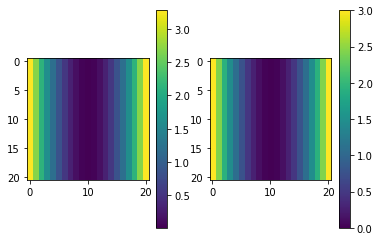

In [30]:
f = xx**3+yy**2
gf = fd.grad(f)
plt.subplot(121)
plt.imshow(gf[0])
plt.colorbar()
plt.subplot(122)
plt.imshow(3*xx**2)
plt.colorbar()

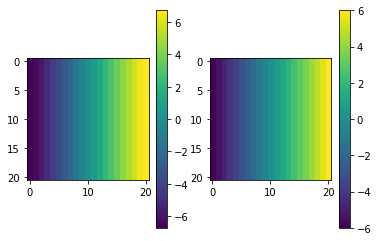

In [31]:
plt.subplot(121)
plt.imshow(np.gradient(fd.grad(f)[0],dx,axis=1,edge_order=2))
plt.colorbar()
plt.subplot(122)
plt.imshow(6*xx)
plt.colorbar()

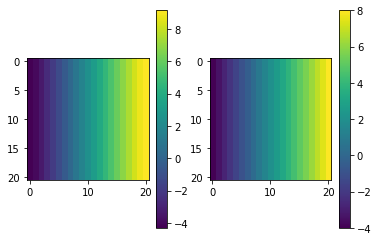

In [32]:
plt.subplot(121)
plt.imshow(fd.divGrad(f))
plt.colorbar()
plt.subplot(122)
plt.imshow(6*xx+2)
plt.colorbar()

## Dirichlet

In [33]:
#GRID
n,m=21,21
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = 1/(n+1)
dy = 1/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
fd = finite_differences(m,n,dx,dy)

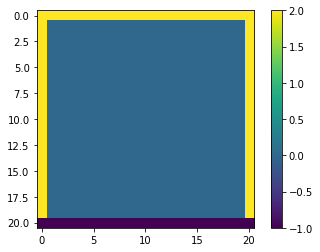

In [34]:
interior = np.ones(domain_shape)
interior[0,:]=np.zeros(n); interior[-1,:]=np.zeros(n)
interior[:,0]=np.zeros(m); interior[:,-1]=np.zeros(m)
dirichlet_loc = np.ones(domain_shape)-interior
dirichlet_bcs = dirichlet_loc*2*np.ones(domain_shape)
dirichlet_bcs[-1,:] = -1*np.ones(n)
plt.imshow(dirichlet_bcs)
plt.colorbar()


In [35]:
primal = lambda v : (interior*(fd.divGrad(v.reshape(domain_shape)))
                                +dirichlet_loc*(v.reshape(domain_shape)-dirichlet_bcs)).reshape(domain_len)
u = fsolve(primal,np.ones(domain_len))

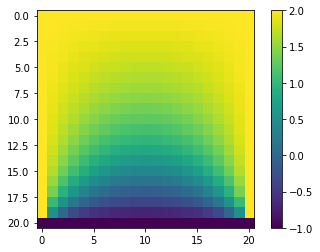

In [36]:
plt.imshow(u.reshape(domain_shape))
plt.colorbar()

## Mixed

In [37]:
#GRID
n,m=20,20
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = 2/(n+1)
dy = 2/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
fd = finite_differences(m,n,dx,dy)

In [70]:
interior = np.ones(domain_shape)
interior[0,:]=np.zeros(n); interior[-1,:]=np.zeros(n)
interior[:,0]=np.zeros(m); interior[:,-1]=np.zeros(m)
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:,0]=np.ones(n)
neumann_loc[0,:,-1]=np.ones(n)
dirichlet_bcs = np.zeros(domain_shape)
dirichlet_bcs[-1,:]=np.ones(n);  dirichlet_bcs[0,:]=np.zeros(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[-1,:]=np.ones(n);dirichlet_loc[0,:]=np.ones(n)

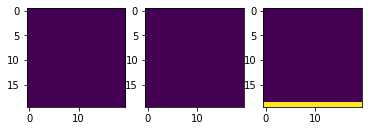

In [71]:
plt.subplot(131)
plt.imshow(neumann_bcs[0])
plt.subplot(132)
plt.imshow(neumann_bcs[1])
plt.subplot(133)
plt.imshow(dirichlet_bcs)

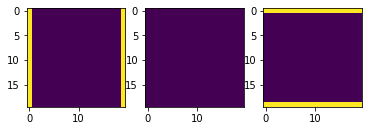

In [72]:
plt.subplot(131)
plt.imshow(neumann_loc[0])
plt.subplot(132)
plt.imshow(neumann_loc[1])
plt.subplot(133)
plt.imshow(dirichlet_loc)

In [73]:
primal = lambda v : (interior*(fd.divGrad(v))
                                +dirichlet_loc*(v.reshape(domain_shape)-dirichlet_bcs)
                                +neumann_loc[0]*(fd.grad(v)[0]-neumann_bcs[0])
                                +neumann_loc[1]*(fd.grad(v)[1]-neumann_bcs[1])
                                ).reshape(domain_len)
u = fsolve(primal,np.zeros(domain_len))

/home/justin/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [74]:
fd.grad(u)[0,-1,:]
# neumann_bcs[1,-1,:]
neumann_loc[0,-1,:]
(neumann_loc[0]*((fd.grad(u)[0])-neumann_bcs[0]))[-1,:]
(neumann_loc[1]*((fd.grad(u)[1])-neumann_bcs[1]))[-1,:]
# (dirichlet_loc*(u.reshape(domain_shape)-dirichlet_bcs))[-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

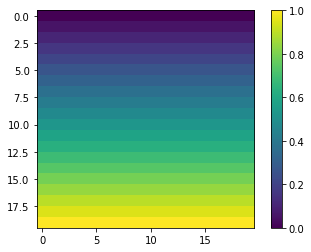

In [75]:
plt.imshow(u.reshape(domain_shape))
plt.colorbar()